# Etap 2
*Nel Kułakowska *
*Marcin Wawrzyniak *

## Komentarze ogólne  
- Projekt napisany w Python wersja 3.10
- Ostateczny wykaz atrybutów:
    - **popularity** - popularność artysty (suma wartości popularity wszystkich jego utworów)  
    - **time_played_3_months_before** - łączny czas słuchania artysty przez użytkowników 3 miesiące przed predykcją  
    - **likes_3_months_before** - łączna liczba polubień utworów artysty 3 miesiące przed predykcją  
    - **play_without_skip_3_months_before** - łączna liczba przesłuchań utworów artysty bez przewinięcia (utwór wysłuchany w całości)  
    - **play_with_skip_3_months_before** - łączna liczba przesłuchań utworów artysty z przewinięciem  
    - **analogiczne atrybuty dla miesiąca 1 i 2 przed przewidywanym**  
    - **month_to_predict** - miesiąc, na który ma zostać przeprowadzona predykcja  
- Napotkane problemy:
    - **obróbka i preprocessing danych**
        - ze względu na ich ilość (ponad 4GB danych w pliku sessions.jsonl) preprocesing był bardzo długotrwały i uciążliwy
        - rozmiar danych uniemożliwiał pracę na "surowych danych" - próba pobrania wszystkich danych na raz kończyła się błędami jądra systemowego  
        - problem rozwiązano poprzez znaczną agregację pliku sessions.jsonl, najpierw ze względu na utwór (etap I), a następnie ze względu na artystę (etap II)
        - modele operują na danych zagregoanych ze względu na artystę  
    - **eksperyment A/B**  
        - ze względu na problematyczną obróbkę danych, do przeprowadzenia eksperymentu A/B stworzono oddzielny endpoint, do którego przesyłane są już zagregowane dane
    - **atrybuty**
        - pomimo dużych korelacji liniowych czasu słuchania artysty w przeszłuch 3 miesiącach i w następnym, początkowo modele nie dawały zadowalających wyników  
        - bardzo pomocne okazało się dodanie jako atrybutu miesiąca, na który zostaje przeprowadzana predykcja (w postaci liczbowej), gdyż pozwoliło uwzględnić sezonowość
- Popełnione błędy:  
    - w pierwszych iteracjach uczenia modeli zbiór testowy i treningowy tworzono losując z zebranych danych próbki do uczenia i testowania  
    - było to błędem, ponieważ w takiej sytuacji modele posiadały informacje na temat przyszłości - w zbiorze treningowym znajdowały się dane z wszystkich miesięcy  
    - problem rozwiązano poprzez ręczny podział danych:  
        - dane trenujące - dane reprezentujące predykcje na miesiące kwiecień-wrzesień  
        - dane testujące - dane reprezentujące predykcje na miesiące październik-listopad
        - grudzień został pominięty
            - przez cały rok czas słuchania wszystkich artystów ma tendencję rosnącą, jednak w grudniu tendencja ta zupełnie się zmienia - każdy artysta był słuchany dużo mniej, niż w listopadzie  
            - modele nie będą w stanie nauczyć się tej zależności na otrzymanych danych, gdyż dane pochodzą z jednego roku  
            - problem można by rozwiązać zbierając dane do testowania np. z następnego roku (w przeciwnym razie nie ma jak wyodrębnić faktycznego zbioru testującego)  
            - w związku z powyższym postanowiliśmy potraktować grudzień jako anomalię i nie brać go po uwagę przy uczeniu i testowaniu  

## Spis plików i folderów projektu  
- Folder **data**  
    - Foldery **test**  
        - dane o kilku wybranych artystach, które można wysłać do mikroserwisu, aby zademonstrować jego działanie  
        - pliki w tym folderze mają format idenczny, jak format "surowych" danych
    - Plik **aggregated.jsonl** - zagregowane ze względu na artystę dane  
    - Plik **tracks_full_info.jsonl** - zagregowane ze względu na utwór dane  
- Folder **src**
    - Folder **data_processing** - skrypty służące do obróbki danych  
    - Folder **help** - zawiera skrypt wyciągający z pliku sessions.jsonl dane demonstracyjne  
    - Folder **microservice**  
        - Folder **templates** - zawiera plik .html z kodem strony internetowej mikroserwisu  
        - Folder **uploads** - folder roboczy mikroserwisu, do którego zapisywane są dane przesłane do predykcji  
        - Skrypt **microservice.py** - zawiera endpointy dla mikroserwisu i uruchamia mikroserwis  
        - Plik **predictions.py** - zawiera funkcje przekazujące dane i predykcje między modelami a mikroserwisem  
    - Folder **models** - zawiera skrypty tworzące modele i same modele zapisane w plikach .pkl  


## Działanie mikroserwisu  
- Mikroserwis działa na localhoscie
- **Uruchomienie mikroserwisu**  
    - Serwis należy uruchamiać z konsoli  
    - Przejść do folderu src/microservice  
    - Wpisać w konsolę: `python3 microservice.py`
    - Mikroserwis uruchomi się na localhost, port 5000  
    - Aby skorzystać z mikroserwisu należy uruchomić przeglądarkę i wpisać `http://127.0.0.1:5000/`  
- Aby otrzymać predykcję należy wysłać 2 pliki:
    1. sessions.jsonl - z sesjami dotyczącymi interesującego nas artysty z ostatnich 3 miesięcy  
    2. tracks.jsonl - z utworami interesującego nas artysty  

    a także podać miesiąc na który ma nastąpić predykcja  
- Serwis wypisze zwróconą przez model wartość w godzinach  

## Testowanie modeli
- Model prosty: LinearRegression
- Model złożony: XGBRegressor

In [45]:
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from src.data_processing.model_utills import get_data_for_model, get_cv_score_mae, get_data_for_model, get_columns, load_model
import random
import numpy as np
import pandas as pd

### Prosty model - hiperparametry

Przetestujemy najważniejsze hiperparametry z pomocą walidacji krzyżowej (gdzie *cv* = 5). Będziemy oceniać MAE.

In [5]:
X_train, y_train, X_test, y_test = get_data_for_model()


model = LinearRegression(copy_X=True)
mae = abs(get_cv_score_mae(model, X_train, y_train))
print("For default parameters MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")
model = LinearRegression(copy_X=True, positive=True)
mae = abs(get_cv_score_mae(model, X_train, y_train))
print("For positive coefficients MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")
model = LinearRegression(copy_X=True, fit_intercept=False)
mae = abs(get_cv_score_mae(model, X_train, y_train))
print("For no intercept MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")
model = LinearRegression(copy_X=True, positive=True, fit_intercept=False)
mae = abs(get_cv_score_mae(model, X_train, y_train))
print("For positive coefficients and no intercept MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")

For default parameters MAE: 13508405.260240829 which is about 225.14 minutes
For positive coefficients MAE: 20941926.07300818 which is about 349.03 minutes
For no intercept MAE: 13144321.99027832 which is about 219.07 minutes
For positive coefficients and no intercept MAE: 20258955.50221073 which is about 337.65 minutes


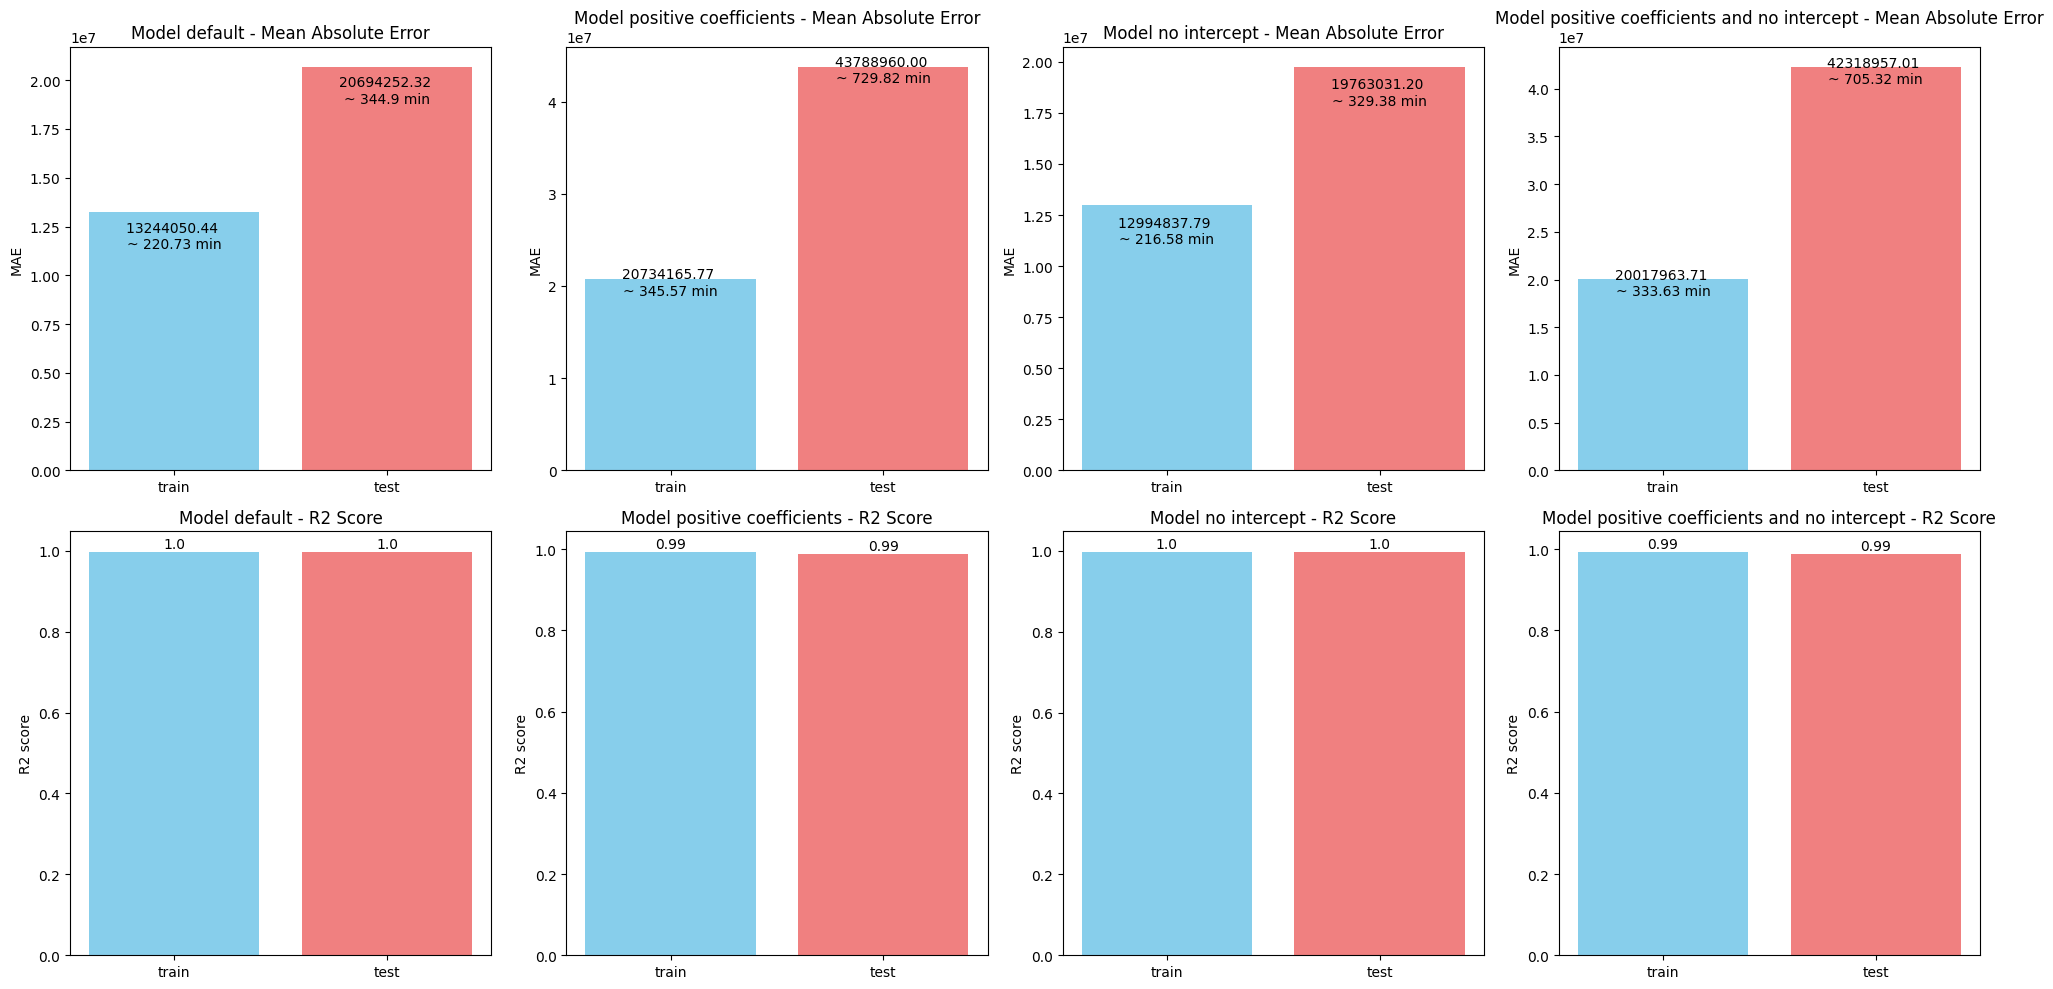

In [25]:
X_train, y_train, X_test, y_test = get_data_for_model()

models = [
    LinearRegression(copy_X=True),
    LinearRegression(copy_X=True, positive=True),
    LinearRegression(copy_X=True, fit_intercept=False),
    LinearRegression(copy_X=True, positive=True, fit_intercept=False)
]
models_names = [
    "default",
    "positive coefficients",
    "no intercept",
    "positive coefficients and no intercept"
]

_, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for j, model in enumerate(models):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    x_axis = ["train", "test"]
    y_axis = ["MAE", "R2 score"]
    maes = [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)]
    r2_scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]

    axes[0, j].bar(x_axis, maes, color=['skyblue', 'lightcoral'])
    axes[0, j].set_ylabel('MAE')
    axes[0, j].set_title(f'Model {models_names[j]} - Mean Absolute Error')
    for i, mae in enumerate(maes):
        mae_min = round(mae / (1000*60), 2)
        axes[0, j].text(i, mae - 2000000, f'{mae:.2f} \n~ {mae_min} min', ha='center', va='bottom')

    axes[1, j].bar(x_axis, r2_scores, color=['skyblue', 'lightcoral'])
    axes[1, j].set_ylabel('R2 score')
    axes[1, j].set_title(f'Model {models_names[j]} - R2 Score')
    for i, r2_score_val in enumerate(r2_scores):
        axes[1, j].text(i, r2_score_val + 0.001, round(r2_score_val, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Jak można zauważyć model nie używający przesunięcia (intercept) działa dużo lepiej niż inne.

In [30]:
X_train, y_train, X_test, y_test = get_data_for_model()
model = LinearRegression(copy_X=True, fit_intercept=False)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("MAE for train:", mean_absolute_error(y_train, y_train_pred), "which is about", round(mean_absolute_error(y_train, y_train_pred)/ (1000*60), 2), "minutes")
print("MAE for test:", mean_absolute_error(y_test, y_test_pred), "which is about", round(mean_absolute_error(y_test, y_test_pred)/ (1000*60), 2), "minutes")

MAE for train: 12994837.793533215 which is about 216.58 minutes
MAE for test: 19763031.199470554 which is about 329.38 minutes


### Złożony model - hiperparametry

Pierwsze spojrzenie na wpływ hiperparametrów na model

In [51]:
hyperparameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [3, 5],
    "subsample": [0.2, 0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [0.1, 1.0],
    "reg_lambda": [0, 10.0],
}

X_train, y_train, X_test, y_test = get_data_for_model()

model = XGBRegressor()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
mae= mean_absolute_error(y_test, y_test_pred)
print("For default parameters MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")

for param, values in hyperparameters.items():
    for value in values:
        model = XGBRegressor(**{param: value})
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        mae= mean_absolute_error(y_test, y_test_pred)
        print("For parameter", param, "with value", value, "MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")

For default parameters MAE: 39001619.11649874 which is about 650.03 minutes
For parameter n_estimators with value 50 MAE: 38812285.998740554 which is about 646.87 minutes
For parameter n_estimators with value 100 MAE: 39001619.11649874 which is about 650.03 minutes
For parameter n_estimators with value 200 MAE: 39076914.94615869 which is about 651.28 minutes
For parameter max_depth with value 3 MAE: 40276465.17962846 which is about 671.27 minutes
For parameter max_depth with value 7 MAE: 38618432.15491184 which is about 643.64 minutes
For parameter learning_rate with value 0.01 MAE: 169652680.3979849 which is about 2827.54 minutes
For parameter learning_rate with value 0.1 MAE: 36907131.00062972 which is about 615.12 minutes
For parameter learning_rate with value 0.2 MAE: 36645592.07052897 which is about 610.76 minutes
For parameter gamma with value 0 MAE: 39001619.11649874 which is about 650.03 minutes
For parameter gamma with value 0.1 MAE: 39001619.11649874 which is about 650.03 min

Przetestujemy najważniejsze hiperparametry z pomocą wariancji krzyżowej (gdzie *cv* = 5). Będziemy oceniać MAE.

In [ ]:
hyperparameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [3, 5],
    "subsample": [0.2, 0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [0.1, 1.0],
    "reg_lambda": [0, 10.0],
}

X_train, y_train, X_test, y_test = get_data_for_model()

model = XGBRegressor()
mae = abs(get_cv_score_mae(model, X_train, y_train))
print("For default parameters MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")

for param, values in hyperparameters.items():
    for value in values:
        model = XGBRegressor(**{param: value})
        mae = abs(get_cv_score_mae(model, X_train, y_train))
        print("For parameter", param, "with value", value, "MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")

For default parameters MAE: 16498895.876971826 which is about 274.98 minutes
For parameter n_estimators with value 50 MAE: 16582063.461826984 which is about 276.37 minutes
For parameter n_estimators with value 100 MAE: 16498895.876971826 which is about 274.98 minutes
For parameter n_estimators with value 200 MAE: 16486757.651189795 which is about 274.78 minutes
For parameter max_depth with value 3 MAE: 17771705.200125597 which is about 296.2 minutes
For parameter max_depth with value 7 MAE: 16784438.89968614 which is about 279.74 minutes
For parameter learning_rate with value 0.01 MAE: 133630619.56182158 which is about 2227.18 minutes
For parameter learning_rate with value 0.1 MAE: 15963436.8376035 which is about 266.06 minutes
For parameter learning_rate with value 0.2 MAE: 15382337.753584549 which is about 256.37 minutes
For parameter gamma with value 0 MAE: 16498895.876971826 which is about 274.98 minutes
For parameter gamma with value 0.1 MAE: 16498895.876971826 which is about 274.

In [39]:
hyperparameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [3, 5],
    "subsample": [0.2, 0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [0.1, 1.0],
    "reg_lambda": [0, 10.0],
}

X_train, y_train, X_test, y_test = get_data_for_model()

model = XGBRegressor()
mae = abs(get_cv_score_mae(model, X_train, y_train))
print("For default parameters MAE:", mae, "which is about", round(mae/ (1000*60), 2), "minutes")

results = []

model = XGBRegressor()
n_iter_search = 300

for i in range(n_iter_search):
    modified_hyperparameters = random.sample(list(hyperparameters.keys()), random.randint(1, len(hyperparameters)))
    fixed_hyperparameters = {
        key: random.choice(values) for key, values in hyperparameters.items() if key in modified_hyperparameters
    }
    subset_hyperparameters = {**fixed_hyperparameters, **{param: random.choice(hyperparameters[param]) for param in modified_hyperparameters}}
    subset_hyperparameters_string = ", ".join([f"{key}: {value}" for key, value in subset_hyperparameters.items()])
    model = XGBRegressor(**subset_hyperparameters)
    mae = abs(get_cv_score_mae(model, X_train, y_train))
    results.append((subset_hyperparameters_string, mae))

results.sort(key=lambda x: x[1])
for result in results[:10]:
    print(f"{result[0]} - MAE: {result[1]}", "which is about", round(result[1]/ (1000*60), 2), "minutes")

For default parameters MAE: 16498895.876971826 which is about 274.98 minutes
n_estimators: 200, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, reg_lambda: 0 - MAE: 15073643.314449945 which is about 251.23 minutes
n_estimators: 200, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, reg_alpha: 1.0, reg_lambda: 0 - MAE: 15073643.36924446 which is about 251.23 minutes
learning_rate: 0.1, gamma: 0, reg_alpha: 0.1, reg_lambda: 10.0 - MAE: 15120377.580598751 which is about 252.01 minutes
max_depth: 7, learning_rate: 0.1, gamma: 0.2, subsample: 0.8, reg_lambda: 10.0 - MAE: 15314070.211184165 which is about 255.23 minutes
n_estimators: 100, learning_rate: 0.1, subsample: 0.8, reg_lambda: 10.0 - MAE: 15361032.6590669 which is about 256.02 minutes
n_estimators: 100, max_depth: 7, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, reg_alpha: 0.1 - MAE: 15367173.351746803 which is about 256.12 minutes
max_depth: 7, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0

Z obu eksperymentów możemy wywnioskować, że na popprawę działania problemu najbardziej wypływa zmiana n_estimators, learning_rate, subsample, colsample_bytree oraz reg_lambda.

In [42]:
hyperparameters = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 700],
    "learning_rate": [0.1, 0.2, 0.3, 0.8],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.2, 0.5, 0.8],
    "reg_lambda": [0, 0.5, 3.0, 10.0],
}

X_train, y_train, X_test, y_test = get_data_for_model()

results = []

n_iter_search = 300

for i in range(n_iter_search):
    modified_hyperparameters = random.sample(list(hyperparameters.keys()), random.randint(1, len(hyperparameters)))
    fixed_hyperparameters = {
        key: random.choice(values) for key, values in hyperparameters.items() if key in modified_hyperparameters
    }
    subset_hyperparameters = {**fixed_hyperparameters, **{param: random.choice(hyperparameters[param]) for param in modified_hyperparameters}}
    subset_hyperparameters_string = ", ".join([f"{key}: {value}" for key, value in subset_hyperparameters.items()])
    model = XGBRegressor(**subset_hyperparameters)
    mae = abs(get_cv_score_mae(model, X_train, y_train))
    results.append((subset_hyperparameters_string, mae))

results.sort(key=lambda x: x[1])
for result in results[:10]:
    print(f"{result[0]} - MAE: {result[1]}", "which is about", round(result[1]/ (1000*60), 2), "minutes")

n_estimators: 600, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, reg_lambda: 0.5 - MAE: 14618200.13222194 which is about 243.64 minutes
n_estimators: 200, learning_rate: 0.1, subsample: 0.7, reg_lambda: 3.0 - MAE: 14823433.554025766 which is about 247.06 minutes
n_estimators: 500, learning_rate: 0.1, subsample: 0.7, reg_lambda: 3.0 - MAE: 14834167.243322005 which is about 247.24 minutes
learning_rate: 0.2, subsample: 0.9, colsample_bytree: 0.8 - MAE: 14971052.855553448 which is about 249.52 minutes
n_estimators: 200, learning_rate: 0.1, subsample: 0.8, reg_lambda: 3.0 - MAE: 15066936.553587962 which is about 251.12 minutes
learning_rate: 0.2, subsample: 0.9, colsample_bytree: 0.5, reg_lambda: 0.5 - MAE: 15094233.453663573 which is about 251.57 minutes
n_estimators: 500, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, reg_lambda: 0 - MAE: 15100775.808377793 which is about 251.68 minutes
learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, reg_lambda: 0 - MA

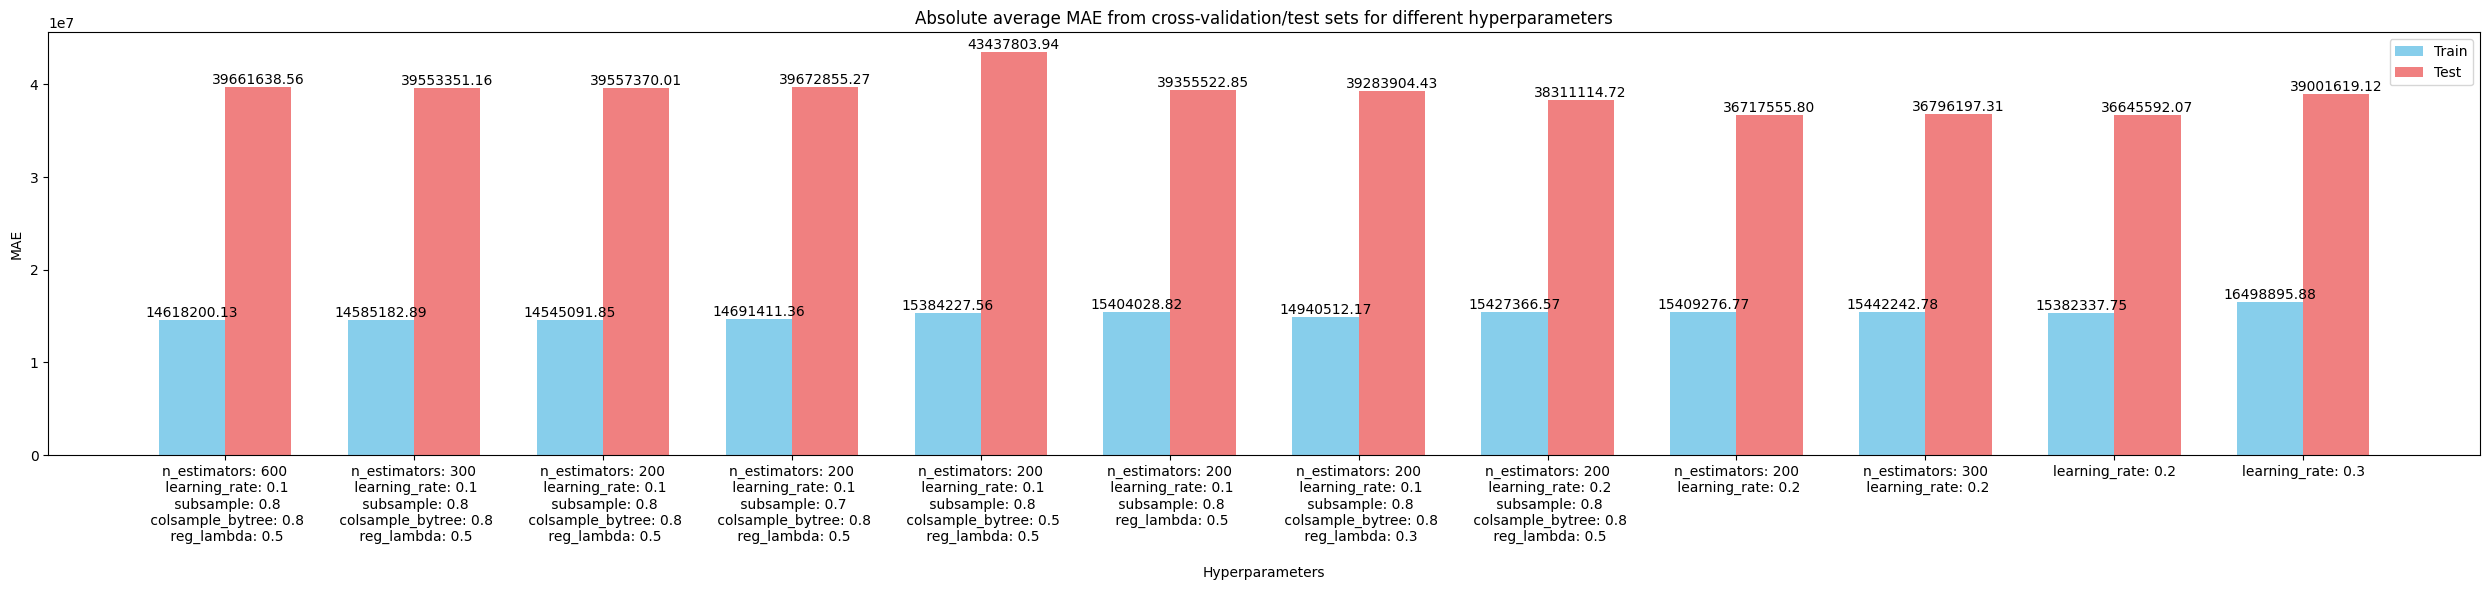

In [48]:
def plot(hyperparameter_values, mae_values, mae_values_test):
    width = 0.35
    x = np.arange(len(hyperparameter_values))

    fig, ax = plt.subplots(figsize=(25, 6))
    bars1 = ax.bar(x - width/2, mae_values, width, label='Train', color='skyblue')
    bars2 = ax.bar(x + width/2, mae_values_test, width, label='Test', color='lightcoral')

    ax.set_ylabel('MAE')
    ax.set_xlabel('Hyperparameters')
    ax.set_title('Absolute average MAE from cross-validation/test sets for different hyperparameters')
    ax.set_xticks(x)
    ax.set_xticklabels(hyperparameter_values)
    ax.legend()

    for bar, mae in zip(bars1, mae_values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mae:.2f}',
                ha='center', va='bottom')

    for bar, mae_test in zip(bars2, mae_values_test):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mae_test:.2f}',
                ha='center', va='bottom')

    fig.tight_layout()

    plt.show()


def evaluate_hyperparameters(X, y, X_test, y_test, hyperparameter_values):
    mae_values = []
    mae_values_test = []
    hyperparameter_values_set = []

    for values_set in hyperparameter_values:
        model = XGBRegressor(**values_set)
        mae = abs(get_cv_score_mae(model, X, y))
        mae_values.append(mae)
        hyperparameters_string = " ".join([f"{key}: {value}\n" for key, value in values_set.items()])
        hyperparameter_values_set.append(hyperparameters_string)
        model = XGBRegressor(**values_set)
        model.fit(X, y)
        y_test_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_test_pred)
        mae_values_test.append(mae)


    plot(hyperparameter_values_set, mae_values, mae_values_test)


hyperparameter_values = [
    {"n_estimators": 600, "learning_rate": 0.1, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5},
    {"n_estimators": 300, "learning_rate": 0.1, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5},
    {"n_estimators": 200, "learning_rate": 0.1, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5},
    {"n_estimators": 200, "learning_rate": 0.1, "subsample": 0.7, "colsample_bytree": 0.8, "reg_lambda": 0.5},
    {"n_estimators": 200, "learning_rate": 0.1, "subsample": 0.8, "colsample_bytree": 0.5, "reg_lambda": 0.5},
    {"n_estimators": 200, "learning_rate": 0.1, "subsample": 0.8, "reg_lambda": 0.5},
    {"n_estimators": 200, "learning_rate": 0.1, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.3},
    {"n_estimators": 200, "learning_rate": 0.2, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5},
    {"n_estimators": 200, "learning_rate": 0.2},
    {"n_estimators": 300, "learning_rate": 0.2},
    {"learning_rate": 0.2},
    {"learning_rate": 0.3}
]
X_train, y_train, X_test, y_test = get_data_for_model()
evaluate_hyperparameters(X_train, y_train, X_test, y_test, hyperparameter_values)

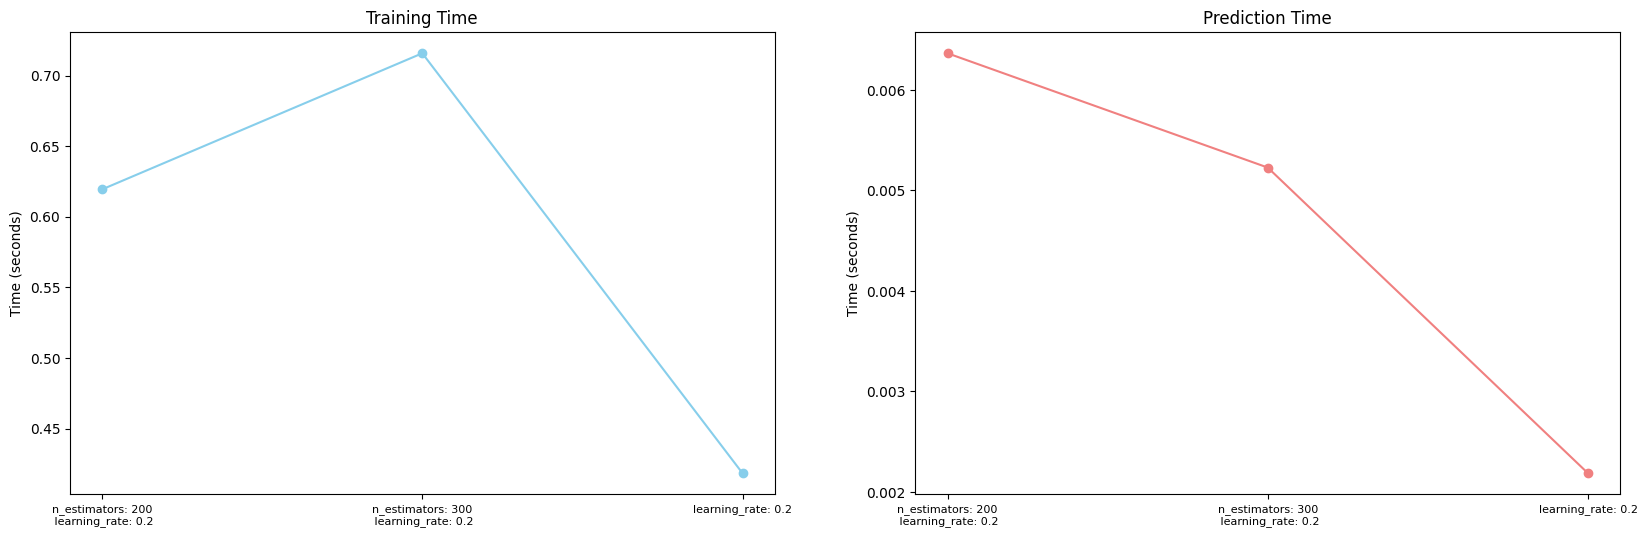

In [49]:
def plot_time(hyperparameter_values, training_times, prediction_times):
    _, ax = plt.subplots(ncols=2, figsize=(20, 6))
    ax[0].plot(hyperparameter_values, training_times, marker='o', label='Training Time', color='skyblue')
    ax[0].set_ylabel('Time (seconds)')
    ax[0].set_title('Training Time')
    ax[1].plot(hyperparameter_values, prediction_times, marker='o', label='Prediction Time', color='lightcoral')
    ax[1].set_ylabel('Time (seconds)')
    ax[1].set_title('Prediction Time')
    ax[0].set_xticks(hyperparameter_values)
    ax[0].set_xticklabels(hyperparameter_values, fontsize=8)
    ax[1].set_xticks(hyperparameter_values)
    ax[1].set_xticklabels(hyperparameter_values, fontsize=8)

    plt.show()

def evaluate_time(X_train, y_train, X_test, hyperparameter_values):
    training_times = []
    prediction_times = []
    hyperparameter_values_set = []

    for values_set in hyperparameter_values:
        model = XGBRegressor(**values_set)
        hyperparameters_string = " ".join([f"{key}: {value}\n" for key, value in values_set.items()])
        hyperparameter_values_set.append(hyperparameters_string)

        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        training_times.append(training_time)

        start_time = time.time()
        model.predict(X_test)
        prediction_time = time.time() - start_time
        prediction_times.append(prediction_time)


    plot_time(hyperparameter_values_set, training_times, prediction_times)

hyperparameter_values = [
    {"n_estimators": 200, "learning_rate": 0.2},
    {"n_estimators": 300, "learning_rate": 0.2},
    {"learning_rate": 0.2},
]
X_train, y_train, X_test, y_test = get_data_for_model()
evaluate_time(X_train, y_train, X_test, hyperparameter_values)


Badając te drobne różnice doszliśmy do wniosku, że najlepszym zestawem hiperparametrów jest: {"learning_rate": 0.2}

In [52]:
X_train, y_train, X_test, y_test = get_data_for_model()

model = XGBRegressor(learning_rate=0.2)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
print("MAE for train set:", mae_train, "which is about", round(mae_train/ (1000*60), 2), "minutes")
print("MAE for test set:", mae_test, "which is about", round(mae_test/ (1000*60), 2), "minutes")


MAE for train set: 4296780.156643577 which is about 71.61 minutes
MAE for test set: 36645592.07052897 which is about 610.76 minutes


### Wnioski z badań
Zaskakujące jest to, że już na tym etapie widać, że model regresji liniowej z odpowiednim parametrem (lub przy domyślnych ustawieniach) działa dużo lepiej od modelu XGboost. W drugim przypadku, gdzie mamy złożony model, występuje znaczny overfitting, któremu nie daliśmy rady zapobiec zmieniając hiperparametry.

### Istotność cech


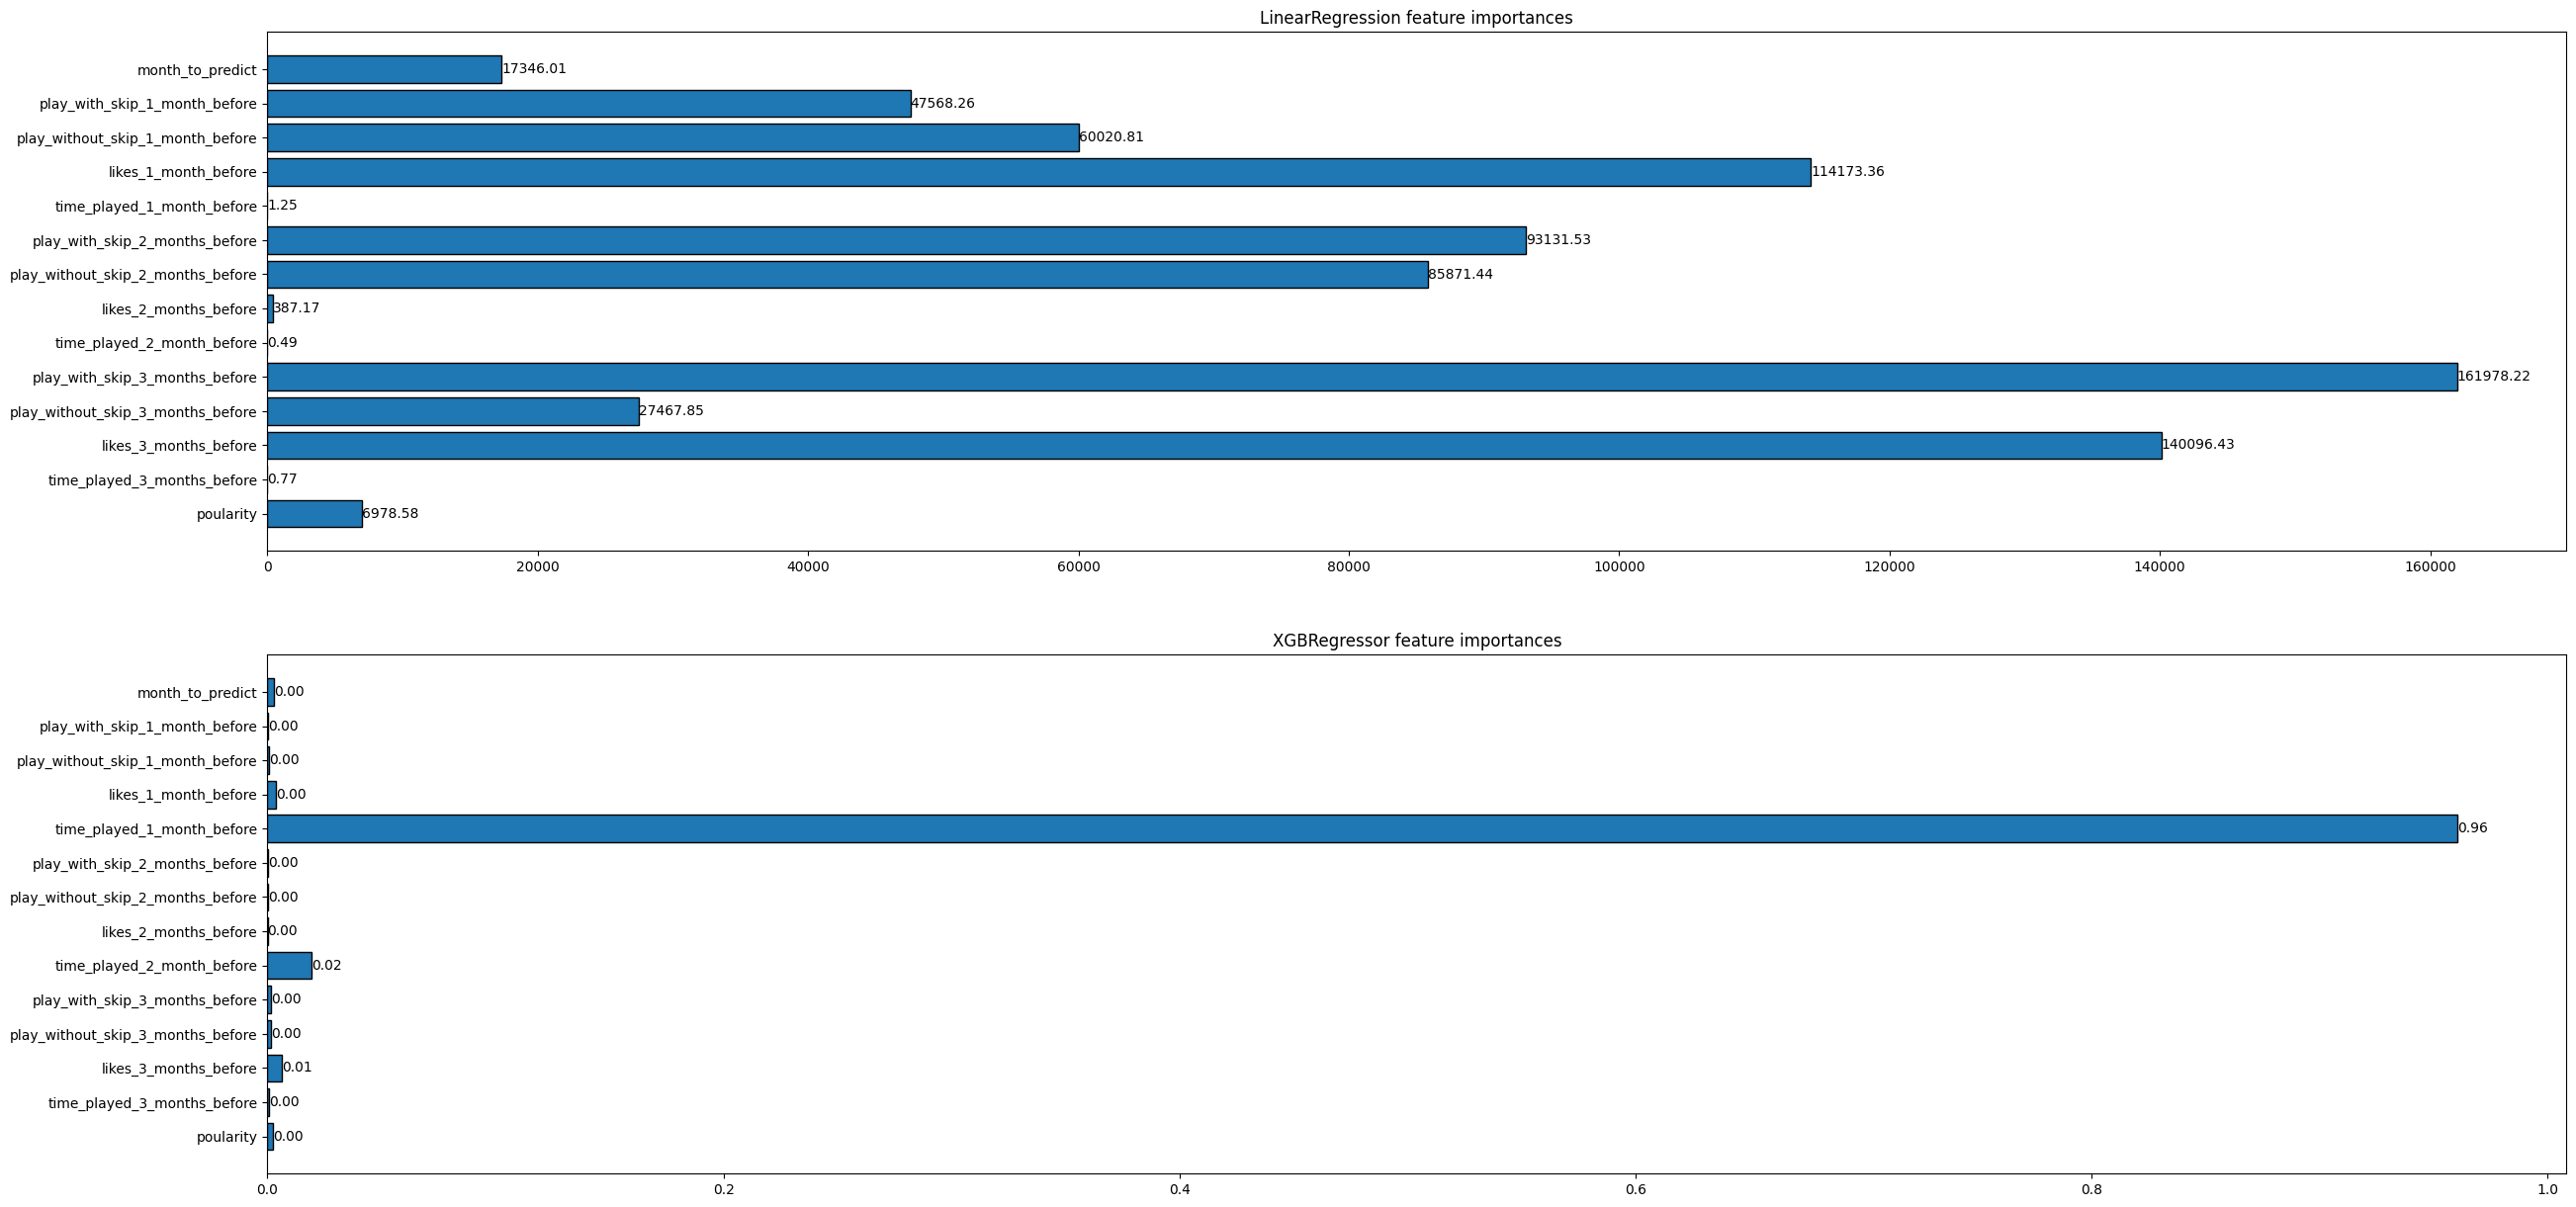

In [46]:
_, axs = plt.subplots(2, 1, figsize=(30, 15))
axs = axs.flatten()
idx = 0

model_linear = load_model("simple_model")
model_XGB = load_model("complex_model")
X_train, y_train, X_test, y_test = get_data_for_model()
model_linear.fit(X_train, y_train)
model_XGB.fit(X_train, y_train)

for model, m_name in zip(
    [model_linear, model_XGB],
    ["LinearRegression", "XGBRegressor"],
):

    names = get_columns()
    values = model.coef_ if hasattr(model, 'coef_') else model.feature_importances_

    a = axs[idx]
    a.barh(y=names, width=abs(values), edgecolor="black")
    a.bar_label(a.containers[0], fmt="%.2f")
    a.set_title(f"{m_name} feature importances")
    idx += 1

plt.show()

W regresji liniowej dużo atrybutów ma spore znaczenie. Zaś w XGBRegressor model praktycznie opiera się tylko na jednym atrybucie, z czego wynika tak duże przeuczenie.

## Test ostatecznych modeli na zbiorze testującym

In [6]:
from sklearn.metrics import mean_absolute_error
from src.data_processing.model_utills import get_data_for_model, get_data_for_model, load_model


simple_model = load_model("simple_model") # model ostateczny (dostrojony) wczytany z pliku
complex_model = load_model("complex_model") # model ostateczny (dostrojony) wczytany z pliku

_, _, X_test, y_test = get_data_for_model()

simple_predictions = simple_model.predict(X_test)
complex_predictions = complex_model.predict(X_test)

simple_mae = mean_absolute_error(y_test, simple_predictions)
complex_mae = mean_absolute_error(y_test, complex_predictions)

print(f"simple model mae: {simple_mae} ms = {simple_mae / 60_000} min = {simple_mae / 3_600_000} h")
print(f"complex model mae: {complex_mae} ms = {complex_mae / 60_000} min = {complex_mae / 3_600_000} h")

simple model mae: 19763031.199470557 ms = 329.3838533245093 min = 5.489730888741821 h
complex model mae: 36645592.07052897 ms = 610.7598678421494 min = 10.179331130702492 h


## Testy A/B
Modele znajdujące się w folderze src/models zostały przygotowane przy pomocy skryptów *simple_model.py* i *complex_model.py*.   
Test będzie przeprowadzony na już zagregowanych danych - danych testowych, używanych wcześniej (serwis udostępnia możliwość wysłania z poziomu przeglądarki "nieprzerobione" dane artysty).  
Wcześniej należy uruchomić mikroserwis (`python3 microservise.py`) w folderze src/microservice.

In [38]:
import requests
from src.data_processing.model_utills import get_test_data, get_data
import os

test_data = get_test_data(get_data())
test_data = test_data.sample(frac=1, random_state=42)
split_index = int(0.5 * len(test_data))
A = test_data.iloc[:split_index]
B = test_data.iloc[split_index:]

results_simple = {"predicted_value": [], "true_value": []}
results_simple = pd.DataFrame(results_simple)
results_complex = {"predicted_value": [], "true_value": []}
results_complex = pd.DataFrame(results_complex)

for model, group in zip(["simple", "complex"], [A, B]):
    for _, row in group.iterrows():
        real_value = row["time_played_to_predict"]
        row = row.drop("time_played_to_predict")
        row = row.to_list()
        data = (model, row)
        url = f"http://127.0.0.1:5000/experiment"
        response = requests.post(url, json=data)
        predicted = response.json().get("prediction")
        new_row = pd.DataFrame({"predicted_value": [predicted], "true_value": [real_value]})
        if model == "simple":
            results_simple = pd.concat([results_simple, new_row], ignore_index=True)
        else:
            results_complex = pd.concat([results_complex, new_row], ignore_index=True)


results_complex.to_csv(os.path.join("AB-results-complex.csv"), index=None)
results_simple.to_csv(os.path.join("AB-results-simple.csv"), index=None)

Po zgromadzeniu danych przeprowadzimy testy - zmierzymy MAE obu modeli oraz przeprowadzimy test t-Studenta

In [39]:
results_simple = pd.read_csv("AB-results-simple.csv")
results_complex = pd.read_csv("AB-results-complex.csv")
predicted_simple = results_simple['predicted_value']
predicted_complex = results_complex['predicted_value']
true_complex = results_complex['true_value']
true_simple = results_simple['true_value']

mae_simple = mean_absolute_error(true_simple, predicted_simple)
mae_complex = mean_absolute_error(true_complex, predicted_complex)
print("MAE for simple model:", mae_simple, "which is about", round(mae_simple/ (1000*60), 2), "minutes")
print("MAE for complex model:", mae_complex, "which is about", round(mae_complex/ (1000*60), 2), "minutes")

MAE for simple model: 20804867.331104513 which is about 346.75 minutes
MAE for complex model: 35294037.115869015 which is about 588.23 minutes


In [43]:
from scipy.stats import ttest_ind

differences_simple = true_simple - predicted_simple
differences_complex = true_complex - predicted_complex

print("Null hypothesis: The complex model is about as good as simple model.")

t_statistic, p_value = ttest_ind(differences_simple, differences_complex, equal_var=True)


print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

alpha = 0.01

if p_value < alpha:
    print("Reject the null hypothesis: The complex model is worse than the simple model.")
else:
    print("Fail to reject the null hypothesis: There is no evidence that the complex model is worse than the simple model.")

Null hypothesis: The complex model is abou as good as simple model.
T-Statistic: 5.3029977850436465
P-Value: 1.2997394836446903e-07
Reject the null hypothesis: The complex model is worse than the simple model.


Oba testy pozwoliły nam na odrzucenie hipotezy zerowej - model skomplikowany nie działa tak samo dobrze jak model prosty.

## Wnioski z projektu  
- W przypadku modelu regresji liniowej udało się osiągnąć oba kryteria sukcesu - analityczne i biznesowe (przewidywania w skali miesiąca różnią się średnio o mniej niż 6h)  
- W przypadku modelu XGBoost nie udało się osiągnąć ani kryterium analitycznego, ani biznesowego  
- Zarówno testy na danych testujących, jak i eksperyment A/B wykazały, że model prosty (regresja liniowa) radzi sobie z problemem lepiej, niż XGBoost  
- Prawdopodobne przyczyny takiego wyniku testów:  
    - duża korelacja liniowa atrybutów ze zmienną celu  
    - ze względu na powyższą korelację problem jest prosty - XGBoost jest zbyt złożonym modelem dla tego zadania, a tym samym nadmiernie dopasowuje się do danych  
    - branie pod uwagę przez XGBoost w zasadzie tylko jednego atrybutu, podczas gdy model regresji korzysta z wielu
- Przebieg projektu potwierdza, że prosty model często może dać lepsze wyniki, niż model skomplikowany